In [23]:
from itertools import product
import tqdm
import time
import editdistance 
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np
import numba as nb
from numba import njit, jit, prange, cuda, objmode
from numba.typed import List
from numba.experimental import jitclass
import plotly.graph_objects as go
import random
from collections import defaultdict
from tqdm import tqdm
np.random.seed(0)
random.seed(0)

In [21]:
@njit(fastmath=True)
def l2_dist(a, b): 
    d = a-b
    return np.sum(d*d);


@njit(fastmath=True)
def hamming_distance(a, b):
    return np.sum(a != b);


# only works for k<=32, would overflow otherwise 
@njit(fastmath=True)
def extract_kmers(seq,k):
    kmer = 0
    kmers = np.zeros(len(seq)-k+1,dtype=np.int64)
    for i,c in enumerate(seq):
        kmer = kmer * 4 + c
        kmer = kmer % (4**k)
        if i>=k:
            kmers[i-k] = kmer
    return kmers

@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('signs', nb.float32[:, :])])
class TS():
    def __init__(self, t, D, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T

    def sketch_one(self, seq: np.ndarray) -> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])

        sketch = sketch.flatten()
        return sketch

    def sketch(self, seqs):
        return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    
class TSS():
    def __init__(self, seq_len, t, W, S, D, A, normalize = True, sketch_class=TS):
        # reduce sketch dim to ensure that the flattened sketch size is D 
        D2 = int(D/int((seq_len-W)/S)+1)   
        self.sketcher = sketch_class(t=t,D=D2,A=A,normalize=normalize)
        self.t = t
        self.W = W
        self.S = S
        self.D2 = D2
        self.D = D
    
    def sketch_one(self, seq: nb.int32[:]) -> nb.float32[:,:]:
        L = int(np.ceil((len(seq)-self.W+1)/self.S))
        sketch = np.zeros((self.D2,L), dtype=np.float32)
        for si,i in enumerate(np.arange(0,len(seq)-self.W+1,self.S)):
            sketch[:,si] = self.sketcher.sketch_one(seq[i:i+self.W])
        
        return sketch
    
    def sketch(self, seqs):
        all_seqs = List()
        starts = np.arange(0,len(seqs[0])-self.W+1,self.S)
        n, m = len(seqs),len(starts)
        for seq in seqs:
            for i in starts:
                all_seqs.append(seq[i:i+self.W])
        all_sketches = self.sketcher.sketch(all_seqs)
        sketches = List()
        for i in range(n):
            sk = np.array([x for sk in all_sketches[i*m:(i+1) * m] for x in sk])
            sketches.append(sk)
        return sketches
    
    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    
    
@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('D2', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('G', nb.float64[:, :]),
    ('H', nb.float64[:]),
    ('signs', nb.float32[:, :])])
class DTS():
    def __init__(self, t, D, D2, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.D2 = D2
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        # Gaussian matrix for discretization
        self.G = np.empty((self.D , self.D2), dtype=np.float64)
        for i in range(self.D):
            for j in range(self.D2):
                self.G[i,j] = random.normalvariate(0,1)
                
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T
    

    def discretize(self, x: nb.float64[:]) -> np.int64:
        x = x.dot(self.G)
#         H = np.tensordot(self.G, x, axes=(1, 0))
        H = (x>0)
        H = H.reshape(-1,8)
        S = np.zeros((H.shape[0]),np.int64)
        for i in range(H.shape[0]):
            arr = H[i]
            S[i] = (arr[0]<<8) + (arr[0]<<7)|(arr[1]<<6)|(arr[2]<<5)|(arr[3]<<4)|(arr[4]<<3)|(arr[5]<<2)|(arr[6]<<1)|arr[7]
        sh = 0
        for s in S:
            sh = hash(sh) + hash(str(s))
        return sh

    def sketch_one(self, seq: np.ndarray)-> np.int64: #-> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])
        sketch = sketch.flatten()
        sketch = self.discretize(sketch)
        return sketch

    def sketch(self, seqs):
        return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)

1731852455476782847

In [9]:
def print_binary(x, dim):
    s = ""
    for i in range(dim - 1, -1, -1):
        s += str((x >> i) & 1)
    print(s)

def mutate(seq, alphabet, rate):
    new_seq = []
    n = len(seq)
    i = 0
    alg = []
    while i < n:
        chance = np.random.uniform()
        if chance > rate:
            # do nothing
            alg.append(i)
            new_seq.append(seq[i])
            i += 1
        else:
            # choose at random an operation between substitution, insertion, deletion
            op = np.random.choice([0,1,2])            
            if op == 0:
                # substitution
                c = np.random.choice(list(set(alphabet) - set([seq[i]])))
                new_seq.append(c)
                i += 1
            elif op == 1:
                # insertion
                c = np.random.choice(alphabet)
                alg.append(i)
                new_seq.append(c)
            elif op == 2:
                # deletion
                i += 1
    return ''.join(new_seq),alg
    
def convert(seq, alphabet):
    inv_map = {alphabet[i]:i for i in range(len(alphabet))}
    new_seq = []
    for c in seq:
        new_seq.append(inv_map[c])
    return np.asarray(new_seq, dtype=np.uint8)

def generate_paths(seq, path_len, num_paths, k, mutation_rate, alphabet):
    paths = []
    for i in range(num_paths):
        # pick random index
        start = np.random.choice(len(seq) - path_len)
        path = seq[start:start+path_len]
        seq2, align =  mutate(path, alphabet, mutation_rate)
        nodes = [start+i for i in align]
        paths.append((path,seq2, nodes))
    return paths

def get_discrete_mmer_sketches(mmers, N, m, alphabet, G, sketcher):
    sketches = []
    for mmer in mmers:
        sketch = sketcher.sketch_one(convert(mmer, alphabet))
        sketches.append(sketch)

    assert len(sketches) == N - m + 1, f"{len(sketches)} != {N - m + 1}"
    return sketches

def get_kmer_sketches(mmer_sketches, N, k, m, stride, embed_dim,stride2):
    num_windows = int(np.ceil((k - m + 1) / stride))

    kmer_sketches = []
    for kmer in range(0, N - k + 1, stride2):
        kmer_sketch = 0
        for mmer in range(kmer, kmer + num_windows * stride, stride):
            for bit in range(embed_dim - 1, -1, -1):
                kmer_sketch <<= 1
                kmer_sketch |= ((mmer_sketches[mmer] >> bit) & 1)
        kmer_sketches.append(kmer_sketch)
    return kmer_sketches

def build_lookup(sketches, stride):
    lut = defaultdict(list)
    for i, s in enumerate(sketches):
        lut[s].append(i*stride)
    return lut

def dict_configs(d):
    for k,v in d.items():
        if not isinstance(v,list):
            d[k] = [v]
    for vcomb in product(*d.values()):
        yield dict(zip(d.keys(), vcomb))
        


In [85]:
alphabet = np.array(['A', 'C', 'T', 'G'])

results = []

w = 15 

config_grid = dict(
    num_paths = 1000,
    N = [ 100000],
    mutation_rate = [ 0.1, .2, 0.3],
    path_len = 200,
    tuple_length = [3],
    k=w,
    embed_dim=[30],
    embed_dim2=[2**8],
    recall_distance = 0,
    m = w,
    stride = [w],
    stride2 = [ w],
)

for conf in dict_configs(config_grid):
    N = conf['N']
    k = conf['k']
    m = conf['m']
    num_paths = conf['num_paths']
    recall_distance = conf['recall_distance']
    mutation_rate = conf['mutation_rate']
    path_len = conf['path_len']
    stride = conf['stride']
    stride2 = conf['stride2']
    tuple_length = conf['tuple_length']
    embed_dim = conf['embed_dim'] 
    embed_dim2 = conf['embed_dim2']   

    seqInt = np.random.randint(0,len(alphabet), (N))
    seqv = alphabet[seqInt]
    seq = ''.join(seqv)
    sketcher = DTS(t=tuple_length, D=embed_dim, D2=embed_dim2, A=len(alphabet))    

    # Change this to use TSS!
    mmers = [seqInt[i:i+m] for i in range(N - m + 1)]
    mmer_sketches = sketcher.sketch(mmers)
    sketches = get_kmer_sketches(mmer_sketches, N, k, m, stride, embed_dim2,stride2)
    lut = build_lookup(sketches, stride2)

    paths = generate_paths(seq, path_len, num_paths, k, mutation_rate, alphabet)
    recall = np.array([False for _ in range(num_paths)])
    hits = np.array([0 for _ in range(num_paths)])
    tp = np.array([0 for _ in range(num_paths)])
    dists = []
    num_found_hits = 0
    hits_out_of_total = ([0 for _ in range(num_paths)])

    for i, path in enumerate(tqdm(paths)):
        reference, query, node_path = path
        queryInt = convert(query, alphabet)
        query_mmers = [queryInt[j:j+m] for j in range(len(query) - m + 1)]
        query_mmer_sketches = sketcher.sketch(query_mmers)
        query_sketches = get_kmer_sketches(query_mmer_sketches, len(query), k, m, stride, embed_dim2,stride2=1)

        # Lookup
        for qi,query_sketch in enumerate(query_sketches):
            if query_sketch not in lut:
                continue
            for node in lut[query_sketch]: # for each node j in the matches
                hits[i] += 1 # count a hit
                ri = (node-node_path[0]) # relative node location to reference head 
                d1 = editdistance.eval(reference[:ri], query[:qi])
                d2 = editdistance.eval(reference[ri:], query[qi:])
                d = editdistance.eval(reference, query)
                dists.append(d1+d2-d)
                if(  d1+d2 <= d + recall_distance):
                    tp[i] += 1
                    recall[i] = 1

        hits_out_of_total[i] = hits[i] / (N - k + 1)
    seqs_that_hit = np.argwhere(hits > 0)
    counts,bins = np.histogram(dists,bins=list(range(10))+[1e9]);
    conf['precision'] = np.sum(tp) / np.sum(hits)
    conf['recall'] = np.mean(recall) 
    conf['brute_force'] = np.sum(hits_out_of_total) / len(seqs_that_hit)
    conf['dists_bins'] = bins[:-1]
    conf['dists_counts'] = counts
    results.append(conf)
    print('\n',conf)    

df = pd.DataFrame(results)
df[['N','k','mutation_rate','recall_distance','embed_dim','embed_dim2','precision','recall']]

100%|██████████| 1000/1000 [00:12<00:00, 79.82it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.1, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 256, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.9472765363128491, 'recall': 0.927, 'brute_force': 2.9469146256607616e-05, 'dists_bins': array([0.0e+00, 1.0e+00, 2.0e+00, 3.0e+00, 4.0e+00, 5.0e+00, 6.0e+00,
       7.0e+00, 8.0e+00, 9.0e+00, 1.0e+01, 1.1e+01, 1.2e+01, 1.3e+01,
       1.4e+01, 1.5e+01, 1.6e+01, 1.7e+01, 1.8e+01, 1.9e+01, 1.0e+09]), 'dists_counts': array([2713,   18,  116,    1,   14,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    2])}


100%|██████████| 1000/1000 [00:12<00:00, 80.59it/s]



 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.2, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 256, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8707482993197279, 'recall': 0.393, 'brute_force': 1.295335531996506e-05, 'dists_bins': array([0.0e+00, 1.0e+00, 2.0e+00, 3.0e+00, 4.0e+00, 5.0e+00, 6.0e+00,
       7.0e+00, 8.0e+00, 9.0e+00, 1.0e+01, 1.1e+01, 1.2e+01, 1.3e+01,
       1.4e+01, 1.5e+01, 1.6e+01, 1.7e+01, 1.8e+01, 1.9e+01, 1.0e+09]), 'dists_counts': array([512,  11,  49,   1,  14,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1])}


100%|██████████| 1000/1000 [00:12<00:00, 79.97it/s]


 {'num_paths': 1000, 'N': 100000, 'mutation_rate': 0.3, 'path_len': 200, 'tuple_length': 3, 'k': 15, 'embed_dim': 30, 'embed_dim2': 256, 'recall_distance': 0, 'm': 15, 'stride': 15, 'stride2': 15, 'precision': 0.8607594936708861, 'recall': 0.063, 'brute_force': 1.0823433088851617e-05, 'dists_bins': array([0.0e+00, 1.0e+00, 2.0e+00, 3.0e+00, 4.0e+00, 5.0e+00, 6.0e+00,
       7.0e+00, 8.0e+00, 9.0e+00, 1.0e+01, 1.1e+01, 1.2e+01, 1.3e+01,
       1.4e+01, 1.5e+01, 1.6e+01, 1.7e+01, 1.8e+01, 1.9e+01, 1.0e+09]), 'dists_counts': array([68,  3,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  2])}


,N,k,mutation_rate,recall_distance,embed_dim,embed_dim2,precision,recall
0,100000,15,0.1,0,30,256,0.947277,0.927
1,100000,15,0.2,0,30,256,0.870748,0.393
2,100000,15,0.3,0,30,256,0.860759,0.063


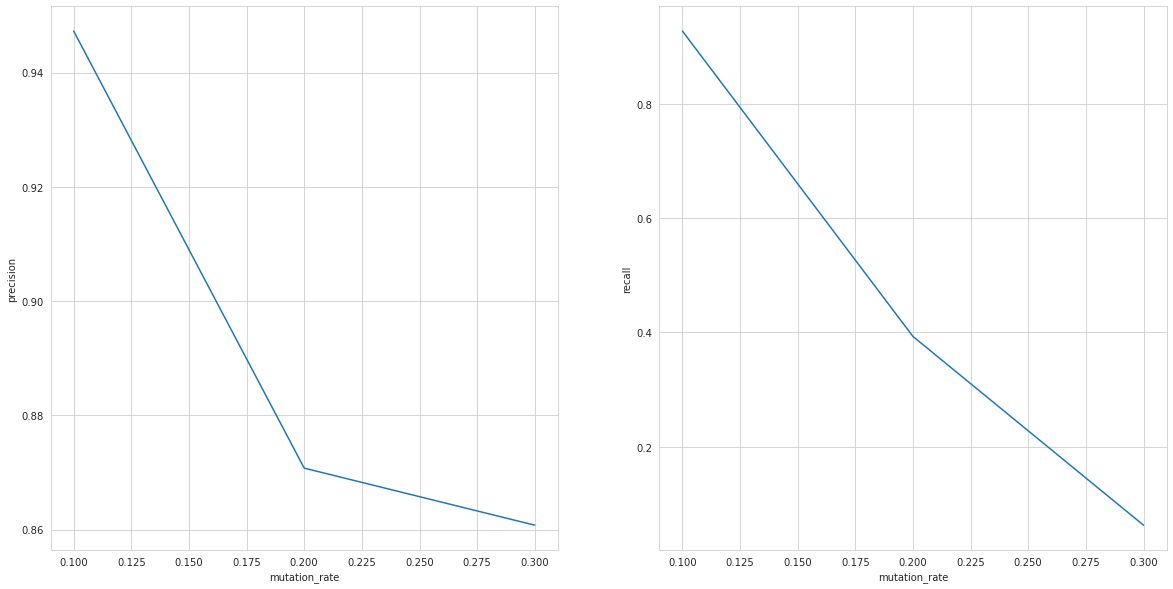

In [91]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(results)
Ys = ['precision', 'recall']
fig,axes = plt.subplots(1,len(Ys),figsize=(len(Ys)*10,10))
for y,ax in zip(Ys,axes):
    sns.set_style("whitegrid")
    sns.lineplot(ax=ax,data=df,y=y,x='mutation_rate')
#     ax.set_ylim(0,1)

plt.grid(True)

In [84]:
c = np.histogram(dists,bins=list(range(20))+[1e9])[0]

(array([66,  6, 10,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1]),
 array([0.0e+00, 1.0e+00, 2.0e+00, 3.0e+00, 4.0e+00, 5.0e+00, 6.0e+00,
        7.0e+00, 8.0e+00, 9.0e+00, 1.0e+01, 1.1e+01, 1.2e+01, 1.3e+01,
        1.4e+01, 1.5e+01, 1.6e+01, 1.7e+01, 1.8e+01, 1.9e+01, 1.0e+09]))

# Measuring time

In [58]:
times = []
# sketcher = TS(t=tuple_length, D=embed_dim, A=len(alphabet))    
sketcher = DTS(t=tuple_length, D=embed_dim, D2=embed_dim2, A=len(alphabet))    

for N in [1000000, 2000000,5000000, 10000000]:
    seqv = np.random.choice(alphabet, N)
    seq = ''.join(seqv)
    mmers = [np.random.randint(0,4,int(15)) for i in range(int(N/15))]
    start = time.time()
    sketcher.sketch(mmers)
#     mmer_sketches = get_discrete_mmer_sketches(mmers, N, m, alphabet, G, sketcher)
    end = time.time()
    print(f'{N}: {end-start}')
    times.append(end-start)


<string>:3: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'seqs' of function 'DTS.sketch'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-21-b1fb5038ad6c>", line 194:

    def sketch(self, seqs):
    ^



1000000: 2.442624807357788
2000000: 2.5908429622650146
5000000: 6.399362087249756
10000000: 12.76330304145813


In [ ]:
seqv = np.random.choice(alphabet, N)
seq = ''.join(seqv)
sketcher = DTS(t=tuple_length, D=embed_dim, D2=embed_dim2, A=len(alphabet))    

# Change this to use TSS!
mmers = [seqv[i:i+m] for i in range(N - m + 1)]
mmer_sketches = get_discrete_mmer_sketches(mmers, N, m, alphabet, G, sketcher)
sketches = get_kmer_sketches(mmer_sketches, N, k, m, stride, embed_dim2,stride2)